In [15]:
%load_ext autoreload

In [20]:
%autoreload 2

In [1]:
from src.parsers import mimic, hirid
from src.modeling import discovery, plots, querier
from src.utils import constants

In [2]:
import sys
# import win32com.client
import os
import pandas as pd

def setup_io_config(root_path):
    """
    Input - Output config. Add dataset paths
    :root_path -> Repo path which contains 'data' and 'res' folders
    """

    # MIMIC
    is_shortcut = True if "data.lnk" in os.listdir(root_path) else False 
    
    if (is_shortcut):
        path_shortcut =  os.path.join(root_path, "data.lnk")
        shell = win32com.client.Dispatch("WScript.Shell")
        mimic_data = shell.CreateShortCut(path_shortcut).Targetpath
    else:
        mimic_data = os.path.join(f"{root_path}", "data") 
    mimic_path = os.path.join(f"{root_path}", "results")

    # HIRID
    hirid_data = f'{root_path}/data/hirid-a-high-time-resolution-icu-dataset-1.1.1/raw_stage/'
    hirid_path = f'{root_path}/data/hirid-a-high-time-resolution-icu-dataset-1.1.1'
    
    return mimic_data, mimic_path, hirid_data, hirid_path

def setup_stratification_config():
    gender="MF"
    age_b=40
    age_a=80 
    ethnicity="WHITE" 
    lab_mapping= constants.LAB_MAPPING
    b_w = [(0,6), (6,12)]
    a_w = [(0,4), (4,8), (8,12)]
    before_windows = b_w
    after_windows = a_w
    return gender, age_a, age_b, ethnicity, lab_mapping, before_windows, after_windows

In [3]:
# IO Config
# root_path ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\MIMIC iii"
root_path = "/Users/pavan/Library/CloudStorage/GoogleDrive-f20190038@hyderabad.bits-pilani.ac.in/My Drive/TAU/Code/DrugLab"
data, res, raw_path, res_path = setup_io_config(root_path=root_path)

# Stratification Config
gender, age_a, age_b, ethnicity, lab_mapping, before_windows, after_windows = setup_stratification_config()

In [20]:
df = pd.read_csv("/Users/pavan/Desktop/TAU/DrugLab/results/stats/hirid Age and LOS subject level.csv")

In [21]:
df["LOS"] = pd.to_timedelta(df["LOS"])

In [22]:
df.describe()

,Unnamed: 0,hadm_id,age,LOS
count,29589.000000,29589.000000,29589.000000,29589
mean,14794.000000,150072.010004,63.251505,8 days 21:54:44.055561188
std,8541.752894,28937.800849,16.250016,8 days 11:57:13.448039941
min,0.000000,100001.000000,20.000000,0 days 07:34:00
25%,7397.000000,124940.000000,52.660000,4 days 07:30:00
50%,14794.000000,150161.000000,65.110000,6 days 19:31:00
75%,22191.000000,175265.000000,76.620000,10 days 14:48:00
max,29588.000000,199999.000000,89.060000,206 days 10:13:00


In [25]:
df = pd.read_csv("/Users/pavan/Desktop/TAU/DrugLab/results/stats/mimic Age and LOS subject level.csv")

In [26]:
df["LOS"] = pd.to_timedelta(df["LOS"])

In [27]:
df.describe()

,Unnamed: 0,hadm_id,age,LOS
count,29589.000000,29589.000000,29589.000000,29589
mean,14794.000000,150072.010004,63.251505,8 days 21:54:44.055561188
std,8541.752894,28937.800849,16.250016,8 days 11:57:13.448039941
min,0.000000,100001.000000,20.000000,0 days 07:34:00
25%,7397.000000,124940.000000,52.660000,4 days 07:30:00
50%,14794.000000,150161.000000,65.110000,6 days 19:31:00
75%,22191.000000,175265.000000,76.620000,10 days 14:48:00
max,29588.000000,199999.000000,89.060000,206 days 10:13:00


In [ ]:
# HIRID
tuples = [(i, i+10) for i in range(120, 241, 10)]
for lab_parts in tuples:
    print(f"Start {lab_parts}....")
    hirid_mapping = constants.HIRID_MAPPING
    hirid_parser = hirid.HiRiDParser(data=raw_path, res=res_path, gender=gender, age_b=age_b, age_a=age_a, load="MANUAL_MAPPING_HIRID")
    h_med1, h_med2, h_labs = hirid_parser.parse(lab_parts=lab_parts)
    h_labs
    'Hemoglobin [Mass/volume] in Blood', 'Hemoglobin [Mass/volume] in Arterial blood'
    
    lab_with_index = h_labs[["HADM_ID", "AGE", "GENDER", "CHARTTIME", "VALUENUM", "ITEMID"]].pivot_table("VALUENUM", ["HADM_ID", "AGE", "GENDER",  "CHARTTIME"], "ITEMID")
    lab_with_index = lab_with_index.reset_index()
    
    disch_time = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER"]).last()
    disch_time["EST_DISCHTIME"] = disch_time["CHARTTIME"]+pd.Timedelta(hours=15)
    disch_time.to_csv(os.path.join(res_path, f"hirid_extract_dischtime_{lab_parts}.csv"))
    
    lab_with_index = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER", lab_with_index.CHARTTIME.dt.date, lab_with_index.CHARTTIME.dt.hour]).mean()
    lab_with_index.to_csv(os.path.join(res_path, f"hirid_extract_new_{lab_parts}.csv"))
    
    print(f"Done with {lab_parts}.")

In [ ]:
# # HIRID
# hirid_mapping = constants.HIRID_MAPPING
# lab_parts = (0,1)
# hirid_parser = hirid.HiRiDParser(data=raw_path, res=res_path, gender=gender, age_b=age_b, age_a=age_a, load="MANUAL_MAPPING_HIRID")
# h_med1, h_med2, h_labs = hirid_parser.parse(lab_parts=lab_parts)

In [5]:
combine_list = [
    ('Hemoglobin [Mass/volume] in Blood', 'Hemoglobin [Mass/volume] in Arterial blood', 'Hemoglobin [Mass/volume] in blood'),
    ('Lactate [Moles/volume] in Venous blood', 'Lactate [Mass/volume] in Arterial blood', 'Lactate [Mass/volume] in blood'),
    ('Invasive diastolic arterial pressure','Non-invasive diastolic arterial pressure', 'Diastolic arterial pressure'),
    ('Invasive systolic arterial pressure','Non-invasive systolic arterial pressure', 'Systolic arterial pressure')
]

In [42]:
# HIRID
tuples = [(i, i+5) for i in range(0, 246, 5)]
for lab_parts in tuples:
    print(f"Start {lab_parts}....")
    hirid_mapping = constants.HIRID_MAPPING
    hirid_parser = hirid.HiRiDParser(data=raw_path, res=res_path, gender=gender, age_b=age_b, age_a=age_a, load="MANUAL_MAPPING_HIRID")
    h_med1, h_med2, h_labs = hirid_parser.parse(lab_parts=lab_parts)
    for c_lab in combine_list:
        l = list(h_labs.ITEMID.value_counts().keys())
        if c_lab[0] in l and c_lab[1] in l:
            h_labs["ITEMID"] = h_labs.ITEMID.apply(lambda r: c_lab[2] if r==c_lab[0] else r)
            h_labs["ITEMID"] = h_labs.ITEMID.apply(lambda r: c_lab[2] if r==c_lab[1] else r)
        
    lab_with_index = h_labs[["HADM_ID", "AGE", "GENDER", "CHARTTIME", "VALUENUM", "ITEMID"]].pivot_table("VALUENUM", ["HADM_ID", "AGE", "GENDER",  "CHARTTIME"], "ITEMID")
    lab_with_index = lab_with_index.reset_index()
    
    disch_time = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER"]).last()
    disch_time["EST_DISCHTIME"] = disch_time["CHARTTIME"]+pd.Timedelta(hours=15)
    # disch_time.to_csv(os.path.join(res_path, f"hirid_extract_dischtime_{lab_parts}.csv"))
    lab_with_index = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER", lab_with_index.CHARTTIME.dt.date, lab_with_index.CHARTTIME.dt.hour]).mean()
    # lab_with_index.to_csv(os.path.join(res_path, f"hirid_extract_new_{lab_parts}.csv"))
    
    final_merged = pd.merge(lab_with_index.reset_index(4).rename(columns={"CHARTTIME":"HOUR"}).reset_index().rename(columns={"CHARTTIME":"DATE"}), disch_time.reset_index()[["HADM_ID", "AGE", "GENDER", "EST_DISCHTIME"]], on=["HADM_ID", "AGE", "GENDER"])
    final_merged["HOUR"] = final_merged.HOUR.astype(int).apply(lambda h: f"0{h}" if h<10 else f"{h}")
    final_merged["DATE"] = final_merged.DATE.astype(str)
    final_merged["CHARTTIME"] = pd.to_datetime(final_merged[["DATE", "HOUR"]].agg(' '.join, axis=1), format="%Y-%m-%d %H")
    
    death_data = hirid_parser.g_table.rename(columns={"patientid":"HADM_ID"})[["HADM_ID", "discharge_status"]]
    final_merged = pd.merge(final_merged, death_data)
    final_merged["EST_DISCHTIME"] = pd.to_datetime(final_merged["EST_DISCHTIME"])
    def get_label(row, hours=48):
        if row["discharge_status"]=="dead" and row["EST_DISCHTIME"]-row["CHARTTIME"] < pd.Timedelta(hours=hours):
            return 1
        else:
            return 0
    final_merged["LABEL_48"] = final_merged.apply(lambda row: get_label(row, hours=48), axis=1)
    
    final_merged = final_merged.drop(columns=["Amylase [Enzymatic activity/volume] in Body fluid","Creatinine [Moles/volume] in Urine","Glucose [Moles/volume] in Cerebral spinal fluid","Lactate [Moles/volume] in Cerebral spinal fluid", 'Metronidazole tabl 200 mg'])
    final_merged.to_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_new_{lab_parts}.csv"))
    print(f"Done with {lab_parts}.")


Start (0, 5)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (0, 5).
Start (5, 10)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (5, 10).
Start (10, 15)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (10, 15).
Start (15, 20)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (15, 20).
Start (20, 25)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (20, 25).
Start (25, 30)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (25, 30).
Start (30, 35)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/245157101

Done with (30, 35).
Start (35, 40)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (35, 40).
Start (40, 45)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (40, 45).
Start (45, 50)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (45, 50).
Start (50, 55)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (50, 55).
Start (55, 60)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/245157101

Done with (55, 60).
Start (60, 65)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (60, 65).
Start (65, 70)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (65, 70).
Start (70, 75)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (70, 75).
Start (75, 80)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (75, 80).
Start (80, 85)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (80, 85).
Start (85, 90)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/245157101

Done with (85, 90).
Start (90, 95)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (90, 95).
Start (95, 100)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (95, 100).
Start (100, 105)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/245157101

Done with (100, 105).
Start (105, 110)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (105, 110).
Start (110, 115)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (110, 115).
Start (115, 120)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (115, 120).
Start (120, 125)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (120, 125).
Start (125, 130)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (125, 130).
Start (130, 135)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (130, 135).
Start (135, 140)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (135, 140).
Start (140, 145)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (140, 145).
Start (145, 150)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (145, 150).
Start (150, 155)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (150, 155).
Start (155, 160)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (155, 160).
Start (160, 165)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (160, 165).
Start (165, 170)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (165, 170).
Start (170, 175)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (170, 175).
Start (175, 180)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (175, 180).
Start (180, 185)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (180, 185).
Start (185, 190)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (185, 190).
Start (190, 195)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (190, 195).
Start (195, 200)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (195, 200).
Start (200, 205)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (200, 205).
Start (205, 210)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (205, 210).
Start (210, 215)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (210, 215).
Start (215, 220)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (215, 220).
Start (220, 225)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (220, 225).
Start (225, 230)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (225, 230).
Start (230, 235)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (230, 235).
Start (235, 240)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (235, 240).
Start (240, 245)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (240, 245).
Start (245, 250)....


/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/Users/pavan/Desktop/TAU/DrugLab/src/parsers/hirid.py:85: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv(path)
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_1594/2451571019.

Done with (245, 250).


In [43]:
parts = [(i, i+5) for i in range(0, 246, 5)]
names = set([])
for lab_parts in parts:
    final_merged = pd.read_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_new_{lab_parts}.csv"))
    names = names.union(set(final_merged.columns))
feature_names = list(names.difference(['Unnamed: 0', 'HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48']))

In [44]:
feature_names

['Pulmonary artery systolic pressure',
 'Methemoglobin/Hemoglobin.total in Arterial blood',
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
 'Heart rate',
 'Potassium [Moles/volume] in Blood',
 'Core body temperature',
 'Respiratory rate',
 'Glucose [Moles/volume] in Serum or Plasma',
 'Bilirubin.direct [Mass/volume] in Serum or Plasma',
 'Chloride [Moles/volume] in Blood',
 'Amylase [Enzymatic activity/volume] in Serum or Plasma',
 'Calcium.ionized [Moles/volume] in Blood',
 'Peripheral oxygen saturation',
 'INR in Blood by Coagulation assay',
 'Sodium [Moles/volume] in Blood',
 'Systolic arterial pressure',
 'Pulmonary artery diastolic pressure',
 'Creatinine [Moles/volume] in Blood',
 'Bilirubin.total [Moles/volume] in Serum or Plasma',
 'Diastolic arterial pressure',
 'Magnesium [Moles/volume] in Blood',
 'Calcium [Moles/volume] in Blood',
 'Lymphocytes [#/volume] in Blood',
 'Lactate [Mass/volume] in blood',
 'Platelets [#/volume] in Blood',
 'Neutrophi

In [45]:
parts = [(i, i+5) for i in range(0, 246, 5)]
paths = []
for lab_parts in parts:
    paths.append(os.path.join(res_path, f"hirid_extract_with_labels_48_new_{lab_parts}.csv"))

In [46]:
final_all_merged = pd.concat([pd.read_csv(path).drop(columns="Unnamed: 0") for path in paths])

In [50]:
final_all_merged

,HADM_ID,AGE,GENDER,DATE,HOUR,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Albumin [Mass/volume] in Serum or Plasma,Amylase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Bicarbonate [Moles/volume] in Arterial blood,...,Potassium [Moles/volume] in Blood,Pulmonary artery diastolic pressure,Pulmonary artery systolic pressure,Respiratory rate,Sodium [Moles/volume] in Blood,Systolic arterial pressure,EST_DISCHTIME,CHARTTIME,discharge_status,LABEL_48
0,148,50,M,2183-05-12,12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,31.0,NaN,155.111111,2183-05-14 01:31:10.010,2183-05-12 12:00:00,alive,0
1,148,50,M,2183-05-12,13,NaN,NaN,NaN,NaN,23.6,...,4.3,NaN,NaN,28.0,136.0,99.000000,2183-05-14 01:31:10.010,2183-05-12 13:00:00,alive,0
2,148,50,M,2183-05-12,14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.160714,2183-05-14 01:31:10.010,2183-05-12 14:00:00,alive,0
3,148,50,M,2183-05-12,15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,NaN,78.111111,2183-05-14 01:31:10.010,2183-05-12 15:00:00,alive,0
4,148,50,M,2183-05-12,16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,NaN,81.689655,2183-05-14 01:31:10.010,2183-05-12 16:00:00,alive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30588,33902,75,F,2182-12-13,9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,88.193548,2182-12-14 04:52:14.430,2182-12-13 09:00:00,alive,0
30589,33902,75,F,2182-12-13,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.0,NaN,88.548387,2182-12-14 04:52:14.430,2182-12-13 10:00:00,alive,0
30590,33902,75,F,2182-12-13,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.655172,2182-12-14 04:52:14.430,2182-12-13 11:00:00,alive,0
30591,33902,75,F,2182-12-13,12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,85.208333,2182-12-14 04:52:14.430,2182-12-13 12:00:00,alive,0


In [48]:
final_all_merged.to_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_all_parts_new.csv"))

In [ ]:
final_merged = final_merged[['HADM_ID', 'AGE', 'GENDER', 'CHARTTIME', 'discharge_status', 'EST_DISCHTIME', 'LABEL_48',
       'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Albumin [Mass/volume] in Serum or Plasma',
       'Amylase [Enzymatic activity/volume] in Body fluid',
       'Amylase [Enzymatic activity/volume] in Serum or Plasma',
       'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Arterial blood',
       'Bilirubin.direct [Mass/volume] in Serum or Plasma',
       'Bilirubin.total [Moles/volume] in Serum or Plasma',
       'Calcium [Moles/volume] in Blood',
       'Calcium.ionized [Moles/volume] in Blood',
       'Carboxyhemoglobin/Hemoglobin.total in Arterial blood',
       'Chloride [Moles/volume] in Blood', 'Core body temperature',
       'Creatinine [Moles/volume] in Blood',
       'Creatinine [Moles/volume] in Urine',
       'Glucose [Moles/volume] in Cerebral spinal fluid',
       'Glucose [Moles/volume] in Serum or Plasma', 'Heart rate',
       'Hemoglobin [Mass/volume] in Arterial blood',
       'Hemoglobin [Mass/volume] in Blood',
       'INR in Blood by Coagulation assay',
       'Invasive diastolic arterial pressure',
       'Invasive systolic arterial pressure',
       'Lactate [Mass/volume] in Arterial blood',
       'Lactate [Moles/volume] in Cerebral spinal fluid',
       'Lactate [Moles/volume] in Venous blood',
       'Lymphocytes [#/volume] in Blood', 'Magnesium [Moles/volume] in Blood',
       'Methemoglobin/Hemoglobin.total in Arterial blood',
       'Metronidazole tabl 200 mg', 'Neutrophils/100 leukocytes in Blood',
       'Non-invasive diastolic arterial pressure',
       'Non-invasive systolic arterial pressure',
       'Peripheral oxygen saturation', 'Platelets [#/volume] in Blood',
       'Potassium [Moles/volume] in Blood',
       'Pulmonary artery diastolic pressure',
       'Pulmonary artery systolic pressure', 'Respiratory rate',
       'Sodium [Moles/volume] in Blood']].set_index(['HADM_ID', 'AGE', 'GENDER', 'CHARTTIME'])

In [23]:
lab_with_index = h_labs[["HADM_ID", "AGE", "GENDER", "discharge_status", "CHARTTIME", "VALUENUM", "ITEMID"]].pivot_table("VALUENUM", ["HADM_ID", "AGE", "GENDER", "discharge_status", "CHARTTIME"], "ITEMID")
lab_with_index = lab_with_index.reset_index()

In [ ]:
disch_time = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER"]).last()
disch_time["EST_DISCHTIME"] = disch_time["CHARTTIME"]+pd.Timedelta(hours=15)
disch_time.to_csv(os.path.join(res_path, f"hirid_extract_dischtime_{lab_parts}.csv"))

In [ ]:
lab_with_index = lab_with_index.groupby(["HADM_ID", "AGE", "GENDER", lab_with_index.CHARTTIME.dt.date, lab_with_index.CHARTTIME.dt.hour]).mean()
lab_with_index.to_csv(os.path.join(res_path, f"hirid_extract_charttime_{lab_parts}.csv"))

/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_771/4164431612.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t_lab_ind.groupby(["HADM_ID", "AGE", "GENDER", t_lab_ind.CHARTTIME.dt.date, t_lab_ind.CHARTTIME.dt.hour]).mean()


ITEMID                                   Heart rate  \
HADM_ID AGE GENDER CHARTTIME  CHARTTIME               
148     50  M      2183-05-12 12                NaN   
                              13                NaN   
                              19          89.428571   
                              20          81.387097   
                              21          71.200000   
                              22          69.766667   
                              23          73.689655   
                   2183-05-13 0           75.935484   
                              1           74.500000   
                              2           80.533333   
                              3           85.966667   
                              4           81.833333   
                              5           77.666667   
                              6           91.612903   
                              7          101.724138   
                              8          103.833333   
                              9           96.645161   
                              10          92.312500   

ITEMID                                   Invasive diastolic arterial pressure  
HADM_ID AGE GENDER CHARTTIME  CHARTTIME                                        
148     50  M      2183-05-12 12                                    106.50000  
                              13                                     65.27027  
                              19                                          NaN  
                              20                                          NaN  
                              21                                          NaN  
                              22                                          NaN  
                              23                                          NaN  
                   2183-05-13 0                                           NaN  
                              1                                           NaN  
                              2                                           NaN  
                              3                                           NaN  
                              4                                           NaN  
                              5                                           NaN  
                              6                                           NaN  
                              7                                           NaN  
                              8                                           NaN  
                              9                                           NaN  
                              10                                          NaN

ITEMID,HADM_ID,AGE,GENDER,CHARTTIME,Heart rate,Invasive diastolic arterial pressure
0,148,50,M,2183-05-12 12:42:00.000,NaN,41.0
1,148,50,M,2183-05-12 12:43:00.000,NaN,83.0
2,148,50,M,2183-05-12 12:44:00.000,NaN,100.0
3,148,50,M,2183-05-12 12:45:00.000,NaN,99.0
4,148,50,M,2183-05-12 12:46:00.000,NaN,99.0
...,...,...,...,...,...,...
495,148,50,M,2183-05-13 10:23:21.480,91.0,NaN
496,148,50,M,2183-05-13 10:25:35.330,89.0,NaN
497,148,50,M,2183-05-13 10:27:49.220,95.0,NaN
498,148,50,M,2183-05-13 10:28:56.150,98.0,NaN


In [4]:
lab_parts = (0, 10)

In [66]:
parts = [(i, i+10) for i in range(0, 241, 10)]
for lab_parts in parts:
    print(f"Start {lab_parts}...")
    disch_time = pd.read_csv(os.path.join(res_path, f"hirid_extract_dischtime_{lab_parts}.csv"))
    lab_with_index = pd.read_csv(os.path.join(res_path, f"hirid_extract_charttime_{lab_parts}.csv"))
    final_merged = pd.merge(lab_with_index.rename(columns={"CHARTTIME":"DATE", "CHARTTIME.1":"HOUR"}), disch_time[["HADM_ID", "AGE", "GENDER", "EST_DISCHTIME"]], on=["HADM_ID", "AGE", "GENDER"])
    
    final_merged["HOUR"] = final_merged.HOUR.astype(int).apply(lambda h: f"0{h}" if h<10 else f"{h}")
    final_merged["CHARTTIME"] = pd.to_datetime(final_merged[["DATE", "HOUR"]].agg(' '.join, axis=1), format="%Y-%m-%d %H")
    hirid_parser = hirid.HiRiDParser(data=raw_path, res=res_path, gender=gender, age_b=age_b, age_a=age_a, load="MANUAL_MAPPING_HIRID")
    death_data = hirid_parser.g_table.rename(columns={"patientid":"HADM_ID"})[["HADM_ID", "discharge_status"]]
    final_merged = pd.merge(final_merged, death_data)
    final_merged["EST_DISCHTIME"] = pd.to_datetime(final_merged["EST_DISCHTIME"])
    def get_label(row, hours=48):
        if row["discharge_status"]=="dead" and row["EST_DISCHTIME"]-row["CHARTTIME"] < pd.Timedelta(hours=hours):
            return 1
        else:
            return 0
    final_merged["LABEL_48"] = final_merged.apply(lambda row: get_label(row, hours=48), axis=1)
    final_merged.to_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_{lab_parts}.csv"))
    print(f"End {lab_parts}.")

Start (0, 10)...
End (0, 10).
Start (10, 20)...
End (10, 20).
Start (20, 30)...
End (20, 30).
Start (30, 40)...
End (30, 40).
Start (40, 50)...
End (40, 50).
Start (50, 60)...
End (50, 60).
Start (60, 70)...
End (60, 70).
Start (70, 80)...
End (70, 80).
Start (80, 90)...
End (80, 90).
Start (90, 100)...
End (90, 100).
Start (100, 110)...
End (100, 110).
Start (110, 120)...
End (110, 120).
Start (120, 130)...
End (120, 130).
Start (130, 140)...
End (130, 140).
Start (140, 150)...
End (140, 150).
Start (150, 160)...
End (150, 160).
Start (160, 170)...
End (160, 170).
Start (170, 180)...
End (170, 180).
Start (180, 190)...
End (180, 190).
Start (190, 200)...
End (190, 200).
Start (200, 210)...
End (200, 210).
Start (210, 220)...
End (210, 220).
Start (220, 230)...
End (220, 230).
Start (230, 240)...
End (230, 240).
Start (240, 250)...
End (240, 250).


In [91]:
parts = [(i, i+10) for i in range(0, 241, 10)]
paths = []
for lab_parts in parts:
    paths.append(os.path.join(res_path, f"hirid_extract_with_labels_48_{lab_parts}.csv"))

In [95]:
final_all_merged = pd.concat([pd.read_csv(path) for path in paths])

In [99]:
final_all_merged.drop(columns="Unnamed: 0").to_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_all_parts.csv"))

In [67]:
parts = [(i, i+10) for i in range(0, 241, 10)]
names = set([])
for lab_parts in parts:
    final_merged = pd.read_csv(os.path.join(res_path, f"hirid_extract_with_labels_48_{lab_parts}.csv"))
    names = names.union(set(final_merged.columns))
feature_names = list(names.difference(['Unnamed: 0', 'HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48']))

In [15]:
final_merged = pd.merge(lab_with_index.rename(columns={"CHARTTIME":"DATE", "CHARTTIME.1":"HOUR"}), disch_time[["HADM_ID", "AGE", "GENDER", "EST_DISCHTIME"]], on=["HADM_ID", "AGE", "GENDER"])

In [35]:
final_merged["HOUR"] = final_merged.HOUR.astype(int).apply(lambda h: f"0{h}" if h<10 else f"{h}")
final_merged["CHARTTIME"] = pd.to_datetime(final_merged[["DATE", "HOUR"]].agg(' '.join, axis=1), format="%Y-%m-%d %H")

In [46]:
hirid_parser = hirid.HiRiDParser(data=raw_path, res=res_path, gender=gender, age_b=age_b, age_a=age_a, load="MANUAL_MAPPING_HIRID")
death_data = hirid_parser.g_table.rename(columns={"patientid":"HADM_ID"})[["HADM_ID", "discharge_status"]]

In [48]:
final_merged = pd.merge(final_merged, death_data)

In [49]:
final_merged["EST_DISCHTIME"] = pd.to_datetime(final_merged["EST_DISCHTIME"])

In [56]:
def get_label(row, hours=48):
    if row["discharge_status"]=="dead" and row["EST_DISCHTIME"]-row["CHARTTIME"] < pd.Timedelta(hours=hours):
        return 1
    else:
        return 0

In [57]:
final_merged["LABEL_48"] = final_merged.apply(lambda row: get_label(row, hours=48), axis=1)

In [62]:
final_merged = final_merged[['HADM_ID', 'AGE', 'GENDER', 'CHARTTIME', 'discharge_status', 'EST_DISCHTIME', 'LABEL_48',
       'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Albumin [Mass/volume] in Serum or Plasma',
       'Amylase [Enzymatic activity/volume] in Body fluid',
       'Amylase [Enzymatic activity/volume] in Serum or Plasma',
       'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Arterial blood',
       'Bilirubin.direct [Mass/volume] in Serum or Plasma',
       'Bilirubin.total [Moles/volume] in Serum or Plasma',
       'Calcium [Moles/volume] in Blood',
       'Calcium.ionized [Moles/volume] in Blood',
       'Carboxyhemoglobin/Hemoglobin.total in Arterial blood',
       'Chloride [Moles/volume] in Blood', 'Core body temperature',
       'Creatinine [Moles/volume] in Blood',
       'Creatinine [Moles/volume] in Urine',
       'Glucose [Moles/volume] in Cerebral spinal fluid',
       'Glucose [Moles/volume] in Serum or Plasma', 'Heart rate',
       'Hemoglobin [Mass/volume] in Arterial blood',
       'Hemoglobin [Mass/volume] in Blood',
       'INR in Blood by Coagulation assay',
       'Invasive diastolic arterial pressure',
       'Invasive systolic arterial pressure',
       'Lactate [Mass/volume] in Arterial blood',
       'Lactate [Moles/volume] in Cerebral spinal fluid',
       'Lactate [Moles/volume] in Venous blood',
       'Lymphocytes [#/volume] in Blood', 'Magnesium [Moles/volume] in Blood',
       'Methemoglobin/Hemoglobin.total in Arterial blood',
       'Metronidazole tabl 200 mg', 'Neutrophils/100 leukocytes in Blood',
       'Non-invasive diastolic arterial pressure',
       'Non-invasive systolic arterial pressure',
       'Peripheral oxygen saturation', 'Platelets [#/volume] in Blood',
       'Potassium [Moles/volume] in Blood',
       'Pulmonary artery diastolic pressure',
       'Pulmonary artery systolic pressure', 'Respiratory rate',
       'Sodium [Moles/volume] in Blood']].set_index(['HADM_ID', 'AGE', 'GENDER', 'CHARTTIME'])

In [63]:
final_merged

discharge_status  \
HADM_ID AGE GENDER CHARTTIME                              
4       75  M      2149-01-08 15:00:00            alive   
                   2149-01-08 16:00:00            alive   
                   2149-01-08 17:00:00            alive   
                   2149-01-08 18:00:00            alive   
                   2149-01-08 19:00:00            alive   
...                                                 ...   
33904   70  F      2162-03-25 08:00:00            alive   
                   2162-03-25 09:00:00            alive   
                   2162-03-25 10:00:00            alive   
                   2162-03-25 11:00:00            alive   
                   2162-03-25 12:00:00            alive   

                                                 EST_DISCHTIME  LABEL_48  \
HADM_ID AGE GENDER CHARTTIME                                               
4       75  M      2149-01-08 15:00:00 2149-01-13 04:21:00.000         0   
                   2149-01-08 16:00:00 2149-01-13 04:21:00.000         0   
                   2149-01-08 17:00:00 2149-01-13 04:21:00.000         0   
                   2149-01-08 18:00:00 2149-01-13 04:21:00.000         0   
                   2149-01-08 19:00:00 2149-01-13 04:21:00.000         0   
...                                                        ...       ...   
33904   70  F      2162-03-25 08:00:00 2162-03-26 03:29:14.280         0   
                   2162-03-25 09:00:00 2162-03-26 03:29:14.280         0   
                   2162-03-25 10:00:00 2162-03-26 03:29:14.280         0   
                   2162-03-25 11:00:00 2162-03-26 03:29:14.280         0   
                   2162-03-25 12:00:00 2162-03-26 03:29:14.280         0   

                                        Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma  \
HADM_ID AGE GENDER CHARTTIME                                                                                      
4       75  M      2149-01-08 15:00:00                                                NaN                         
                   2149-01-08 16:00:00                                                NaN                         
                   2149-01-08 17:00:00                                                NaN                         
                   2149-01-08 18:00:00                                                NaN                         
                   2149-01-08 19:00:00                                                NaN                         
...                                                                                   ...                         
33904   70  F      2162-03-25 08:00:00                                                NaN                         
                   2162-03-25 09:00:00                                                NaN                         
                   2162-03-25 10:00:00                                                NaN                         
                   2162-03-25 11:00:00                                                NaN                         
                   2162-03-25 12:00:00                                                NaN                         

                                        Albumin [Mass/volume] in Serum or Plasma  \
HADM_ID AGE GENDER CHARTTIME                                                       
4       75  M      2149-01-08 15:00:00                                       NaN   
                   2149-01-08 16:00:00                                       NaN   
                   2149-01-08 17:00:00                                       NaN   
                   2149-01-08 18:00:00                                       NaN   
                   2149-01-08 19:00:00                                       NaN   
...                                                                          ...   
33904   70  F      2162-03-25 08:00:00                                       NaN   
                   2162-03-25 

In [61]:
final_merged[final_merged.LABEL_48==1]

,HADM_ID,AGE,GENDER,CHARTTIME,EST_DISCHTIME,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Albumin [Mass/volume] in Serum or Plasma,Amylase [Enzymatic activity/volume] in Body fluid,Amylase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,...,Non-invasive systolic arterial pressure,Peripheral oxygen saturation,Platelets [#/volume] in Blood,Potassium [Moles/volume] in Blood,Pulmonary artery diastolic pressure,Pulmonary artery systolic pressure,Respiratory rate,Sodium [Moles/volume] in Blood,discharge_status,LABEL_48
450,272,80,M,2128-10-16 18:00:00,2128-10-18 13:45:37.500,NaN,NaN,NaN,NaN,NaN,...,NaN,96.200000,NaN,NaN,NaN,NaN,NaN,NaN,dead,1
451,272,80,M,2128-10-16 19:00:00,2128-10-18 13:45:37.500,NaN,NaN,NaN,NaN,NaN,...,NaN,62.714286,NaN,3.9,21.842105,32.157895,15.780645,135.0,dead,1
452,272,80,M,2128-10-16 20:00:00,2128-10-18 13:45:37.500,NaN,NaN,NaN,NaN,NaN,...,NaN,55.482759,NaN,4.4,23.866667,52.166667,12.801724,136.0,dead,1
453,272,80,M,2128-10-16 21:00:00,2128-10-18 13:45:37.500,NaN,NaN,NaN,NaN,NaN,...,NaN,76.833333,NaN,3.2,48.100000,70.266667,11.025000,136.0,dead,1
454,272,80,M,2128-10-16 22:00:00,2128-10-18 13:45:37.500,NaN,NaN,NaN,NaN,NaN,...,NaN,79.466667,NaN,NaN,21.741935,47.900000,11.000000,NaN,dead,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62176,32343,70,M,2118-08-13 16:00:00,2118-08-14 11:39:38.980,NaN,NaN,NaN,NaN,NaN,...,NaN,99.000000,NaN,NaN,NaN,NaN,5.500000,NaN,dead,1
62177,32343,70,M,2118-08-13 17:00:00,2118-08-14 11:39:38.980,NaN,NaN,NaN,NaN,NaN,...,NaN,99.333333,NaN,NaN,NaN,NaN,5.530000,NaN,dead,1
62178,32343,70,M,2118-08-13 18:00:00,2118-08-14 11:39:38.980,NaN,NaN,NaN,NaN,NaN,...,NaN,99.916667,NaN,NaN,NaN,NaN,5.500000,NaN,dead,1
62179,32343,70,M,2118-08-13 19:00:00,2118-08-14 11:39:38.980,NaN,NaN,NaN,NaN,NaN,...,NaN,97.920000,NaN,3.8,NaN,NaN,5.593878,142.0,dead,1


In [260]:
df_data = pd.read_csv(os.path.join(res_path, "hirid_extract_with_labels_48_all_parts.csv"))
filtered = df_data.drop(columns=["Unnamed: 0", "Amylase [Enzymatic activity/volume] in Body fluid","Creatinine [Moles/volume] in Urine","Glucose [Moles/volume] in Cerebral spinal fluid","Lactate [Moles/volume] in Cerebral spinal fluid", 'Metronidazole tabl 200 mg'])

In [261]:
filtered.to_csv(os.path.join(res_path, "hirid_extract_with_labels_48_all_parts_no_fluid.csv"))

In [262]:
filtered

,HADM_ID,AGE,GENDER,DATE,HOUR,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Albumin [Mass/volume] in Serum or Plasma,Amylase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Bicarbonate [Moles/volume] in Arterial blood,...,Platelets [#/volume] in Blood,Potassium [Moles/volume] in Blood,Pulmonary artery diastolic pressure,Pulmonary artery systolic pressure,Respiratory rate,Sodium [Moles/volume] in Blood,EST_DISCHTIME,CHARTTIME,discharge_status,LABEL_48
0,4,75,M,2149-01-08,15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.0,NaN,2149-01-13 04:21:00.000,2149-01-08 15:00:00,alive,0
1,4,75,M,2149-01-08,16,NaN,NaN,NaN,NaN,30.2,...,NaN,3.9,NaN,NaN,NaN,137.0,2149-01-13 04:21:00.000,2149-01-08 16:00:00,alive,0
2,4,75,M,2149-01-08,17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2149-01-13 04:21:00.000,2149-01-08 17:00:00,alive,0
3,4,75,M,2149-01-08,18,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,30.0,NaN,2149-01-13 04:21:00.000,2149-01-08 18:00:00,alive,0
4,4,75,M,2149-01-08,19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31.0,NaN,2149-01-13 04:21:00.000,2149-01-08 19:00:00,alive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600127,33902,75,F,2182-12-13,9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2182-12-14 04:52:14.430,2182-12-13 09:00:00,alive,0
1600128,33902,75,F,2182-12-13,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.0,NaN,2182-12-14 04:52:14.430,2182-12-13 10:00:00,alive,0
1600129,33902,75,F,2182-12-13,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2182-12-14 04:52:14.430,2182-12-13 11:00:00,alive,0
1600130,33902,75,F,2182-12-13,12,NaN,NaN,NaN,NaN,NaN,...,681.0,NaN,NaN,NaN,NaN,NaN,2182-12-14 04:52:14.430,2182-12-13 12:00:00,alive,0


TtestResult(statistic=120.05747587932802, pvalue=0.0, df=39808)


Text(0.5, 0, 'Mass/volume')

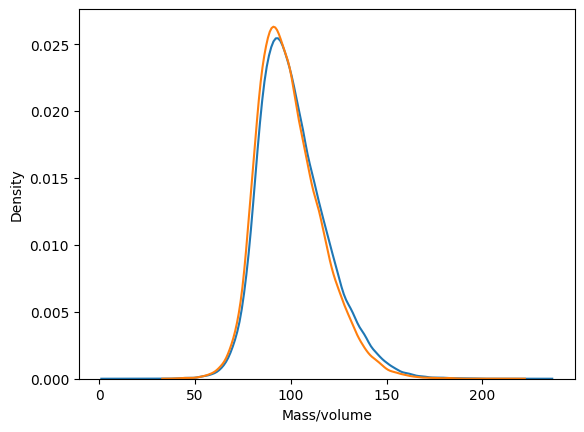

In [263]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
temp_filtered = filtered[['HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48', 'Hemoglobin [Mass/volume] in Blood', 'Hemoglobin [Mass/volume] in Arterial blood']].dropna(subset='Hemoglobin [Mass/volume] in Blood').dropna(subset='Hemoglobin [Mass/volume] in Arterial blood')
print(stats.ttest_rel(temp_filtered["Hemoglobin [Mass/volume] in Arterial blood"], temp_filtered["Hemoglobin [Mass/volume] in Blood"]))
sns.kdeplot(data=temp_filtered, x="Hemoglobin [Mass/volume] in Arterial blood")
sns.kdeplot(data=temp_filtered, x="Hemoglobin [Mass/volume] in Blood")
plt.xlabel("Mass/volume")

TtestResult(statistic=8.601894346207528, pvalue=1.77624076255818e-17, df=1670)


Text(0.5, 0, 'Mass/volume')

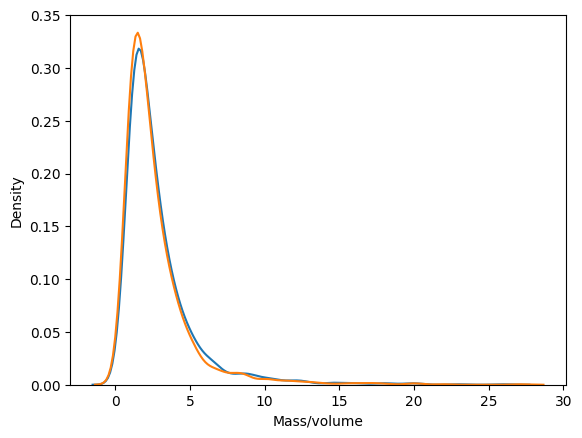

In [264]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
temp_filtered = filtered[['HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48', 'Lactate [Moles/volume] in Venous blood', 'Lactate [Mass/volume] in Arterial blood']].dropna(subset='Lactate [Moles/volume] in Venous blood').dropna(subset='Lactate [Mass/volume] in Arterial blood')
print(stats.ttest_rel(temp_filtered['Lactate [Moles/volume] in Venous blood'], temp_filtered['Lactate [Mass/volume] in Arterial blood']))
sns.kdeplot(data=temp_filtered, x='Lactate [Moles/volume] in Venous blood') # Use this
sns.kdeplot(data=temp_filtered, x='Lactate [Mass/volume] in Arterial blood')
plt.xlabel("Mass/volume")

TtestResult(statistic=6.114071547372929, pvalue=9.785966360147038e-10, df=48505)


Text(0.5, 0, 'Arterial pressure')

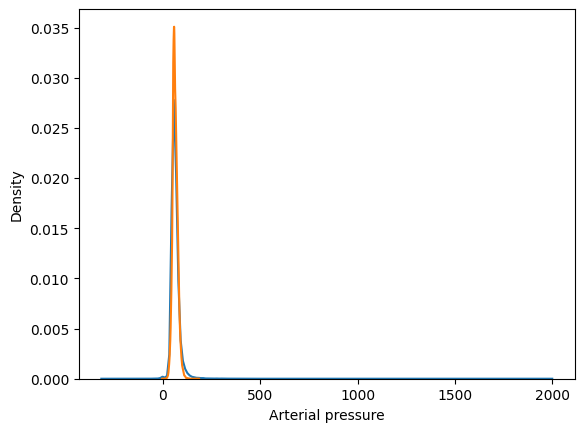

In [265]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
lab1 = 'Invasive diastolic arterial pressure'
lab2 = 'Non-invasive diastolic arterial pressure'
temp_filtered = filtered[['HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48', lab1, lab2]].dropna(subset=lab1).dropna(subset=lab2)
print(stats.ttest_rel(temp_filtered[lab1], temp_filtered[lab2]))
sns.kdeplot(data=temp_filtered, x=lab1)
sns.kdeplot(data=temp_filtered, x=lab2)
plt.xlabel("Arterial pressure")

TtestResult(statistic=31.800783697879396, pvalue=1.1542069839654229e-219, df=48513)


Text(0.5, 0, 'Arterial pressure')

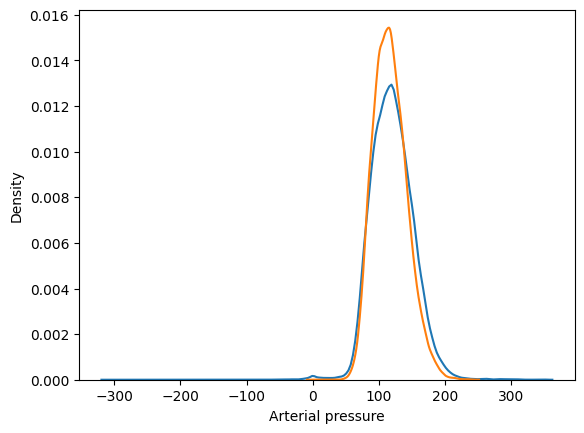

In [266]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
lab1 = 'Invasive systolic arterial pressure'
lab2 = 'Non-invasive systolic arterial pressure'
temp_filtered = filtered[['HADM_ID', 'AGE', 'GENDER', 'DATE', 'HOUR', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48', lab1, lab2]].dropna(subset=lab1).dropna(subset=lab2)
print(stats.ttest_rel(temp_filtered[lab1], temp_filtered[lab2]))
sns.kdeplot(data=temp_filtered, x=lab1)
sns.kdeplot(data=temp_filtered, x=lab2)
plt.xlabel("Arterial pressure")

In [236]:
df_mimic_not_imputed = pd.read_csv(os.path.join("/Users/pavan/Downloads", "df_not_imputed.csv"))

In [267]:
df_mimic_not_imputed.columns

Index(['Unnamed: 0', 'charttime', 'subject_id', 'icustay_id', 'hadm_id',
       'Heart Rate', 'Respiratory rate', 'Oxygen saturation',
       'Systolic blood pressure', 'Diastolic blood pressure', 'Temperature',
       'Glucose', 'Potassium', 'Sodium', 'Chloride', 'Creatinine',
       'Blood urea nitrogen', 'Bicarbonate', 'Calcium', 'Albumin',
       'Lactate dehydrogenase', 'Magnesium', 'Lactic acid', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'White blood cell count', 'Red blood cell',
       'Mean corpuscular volume', 'Lymphocytes', 'Neutrophils',
       'Prothrombin time INR', 'DEATHTIME', 'DISCHTIME', 'ADMITTIME',
       'ETHNICITY', 'GENDER', 'age'],
      dtype='object')

In [237]:
df_mimic_not_imputed

,Unnamed: 0,charttime,subject_id,icustay_id,hadm_id,Heart Rate,Respiratory rate,Oxygen saturation,Systolic blood pressure,Diastolic blood pressure,...,Mean corpuscular volume,Lymphocytes,Neutrophils,Prothrombin time INR,DEATHTIME,DISCHTIME,ADMITTIME,ETHNICITY,GENDER,age
0,0,2100-06-08 23:00:00+00:00,29156,293407,161773,NaN,NaN,NaN,NaN,NaN,...,95.0,16.4,74.6,1.1,2100-06-19 08:15:00,2100-06-19 08:15:00,2100-06-09 01:39:00,WHITE,M,72.18
1,1,2100-06-09 00:00:00+00:00,29156,293407,161773,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2100-06-19 08:15:00,2100-06-19 08:15:00,2100-06-09 01:39:00,WHITE,M,72.18
2,2,2100-06-09 01:00:00+00:00,29156,293407,161773,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2100-06-19 08:15:00,2100-06-19 08:15:00,2100-06-09 01:39:00,WHITE,M,72.18
3,3,2100-06-09 02:00:00+00:00,29156,293407,161773,106.000000,11.000000,100.000000,142.0,67.0,...,NaN,NaN,NaN,NaN,2100-06-19 08:15:00,2100-06-19 08:15:00,2100-06-09 01:39:00,WHITE,M,72.18
4,4,2100-06-09 03:00:00+00:00,29156,293407,161773,114.000000,24.000000,100.000000,138.0,73.0,...,98.0,2.0,96.9,1.1,2100-06-19 08:15:00,2100-06-19 08:15:00,2100-06-09 01:39:00,WHITE,M,72.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877483,1877483,2205-10-28 06:00:00+00:00,86042,255110,191143,108.000000,23.000000,99.000000,111.5,47.5,...,NaN,NaN,NaN,NaN,2205-10-28 10:00:00,2205-10-28 10:00:00,2205-10-24 21:52:00,WHITE,M,82.47
1877484,1877484,2205-10-28 07:00:00+00:00,86042,255110,191143,112.000000,18.000000,100.000000,88.5,45.5,...,NaN,NaN,NaN,NaN,2205-10-28 10:00:00,2205-10-28 10:00:00,2205-10-24 21:52:00,WHITE,M,82.47
1877485,1877485,2205-10-28 08:00:00+00:00,86042,255110,191143,116.333333,26.333333,89.333333,105.0,53.0,...,NaN,NaN,NaN,NaN,2205-10-28 10:00:00,2205-10-28 10:00:00,2205-10-24 21:52:00,WHITE,M,82.47
1877486,1877486,2205-10-28 09:00:00+00:00,86042,255110,191143,116.500000,22.500000,87.666667,93.5,46.0,...,NaN,NaN,NaN,NaN,2205-10-28 10:00:00,2205-10-28 10:00:00,2205-10-24 21:52:00,WHITE,M,82.47


In [ ]:
import numpy as np
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# lab measurements
vital_signs = ['Heart Rate', 'Respiratory rate','Oxygen saturation', 'Systolic blood pressure', 'Diastolic blood pressure',
               'Temperature']
labs_bmp = ['Glucose','Potassium','Sodium','Chloride', 'Creatinine', 'Blood urea nitrogen', 'Bicarbonate', 'Calcium',
            'Albumin', 'Lactate dehydrogenase','Magnesium','Lactic acid']
labs_cbc = ['Hematocrit','Hemoglobin', 'Platelets', 'White blood cell count', 'Red blood cell count',
            'Mean corpuscular volume', 'Lymphocytes', 'Neutrophils']
labs_cauglation = ['Prothrombin time INR']

## Load files
data_path =  os.path.join(f"{res_path}", ".csv")

In [105]:
import numpy as np

In [106]:
#Params
n_patients = 25000
min_p_val = 1e-10
min_no_patients = 100
horizon = '4h'

#Load dataset
df_data = pd.read_csv(os.path.join(res_path, "hirid_extract_with_labels_48_all_parts.csv"))
df_data['CHARTTIME'] = pd.to_datetime(df_data['CHARTTIME'], utc=True)

# Take subset of n_patients=5000
patient_ids = df_data.HADM_ID.unique()
subsample_ids = np.random.choice(patient_ids , size =n_patients) 
df_data = df_data[df_data.HADM_ID.isin(subsample_ids)]

#Taks only a subset of the columns 
df_data = df_data[['HADM_ID', 'AGE', 'GENDER', 'EST_DISCHTIME','CHARTTIME', 'discharge_status', 'LABEL_48']+feature_names]

In [108]:
# Filter only pairs with > 100 patients with signficiant difference (< 1e-10)
df_meds = pd.read_csv('temp_pairs.csv')
df_meds = df_meds[df_meds['No. of Patients'] > min_no_patients]
df_meds = df_meds[(df_meds['BonferroniPvals'] < min_p_val)]

#rename RBC
# df_meds = df_meds.replace('Red blood cell', 'Red blood cell count')

In [112]:
# hirid_parser.load_med()
hirid_parser.pharma_records_with_name

,HADM_ID,ITEMID,STARTTIME,ENDTIME,givendose,cumulativedose,fluidamount_calc,cumulfluidamount_calc,doseunit,route,...,subtypeid,recordstatus,Source Table,LABEL,Unit,Additional information,ADMITTIME,GENDER,AGE,discharge_status
0,81,208,2113-10-07 16:50:00.000,2113-10-07 18:05:58.506,0.00,0.00,0.000,0.000,mg,iv-inf,...,8.0,524,Pharma,Disoprivan 2%,NaN,NaN,2113-10-07 16:50:00,M,75,alive
1,81,208,2113-10-07 17:00:00.000,2113-10-07 18:06:03.473,33.34,33.34,1.667,1.667,mg,iv-inf,...,8.0,520,Pharma,Disoprivan 2%,NaN,NaN,2113-10-07 16:50:00,M,75,alive
2,81,208,2113-10-07 18:06:00.000,2113-10-07 18:06:30.410,0.00,0.00,0.000,0.000,mg,iv-inf,...,8.0,524,Pharma,Disoprivan 2%,NaN,NaN,2113-10-07 16:50:00,M,75,alive
3,81,208,2113-10-07 18:06:00.000,2113-10-07 18:06:10.050,220.00,253.34,11.000,12.667,mg,iv-inf,...,8.0,776,Pharma,Disoprivan 2%,NaN,NaN,2113-10-07 16:50:00,M,75,alive
4,81,208,2113-10-07 18:06:59.560,2113-10-07 18:06:36.910,0.00,0.00,0.000,0.000,mg,iv-inf,...,8.0,520,Pharma,Disoprivan 2%,NaN,NaN,2113-10-07 16:50:00,M,75,alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16270406,2669,1000793,2120-11-14 19:12:00.000,2120-11-14 19:12:50.633,0.50,0.50,2.500,2.500,mg,cv-inj,...,8.0,780,Pharma,Glypressin Inj Lsg,NaN,NaN,2120-11-14 17:15:00,F,65,alive
16270407,2669,1000793,2120-11-15 01:15:00.000,2120-11-15 01:15:00.713,0.50,0.50,2.500,2.500,mg,cv-inj,...,8.0,780,Pharma,Glypressin Inj Lsg,NaN,NaN,2120-11-14 17:15:00,F,65,alive
16270408,5984,1000636,2161-01-16 21:00:00.000,2161-01-16 21:03:26.806,100.00,100.00,1.000,1.000,mg,cv-inj,...,8.0,780,Pharma,Soldactone Amp.,NaN,NaN,2161-01-16 18:05:00,M,65,alive
16270409,5984,1000636,2161-01-17 09:00:00.000,2161-01-17 08:55:29.096,100.00,100.00,1.000,1.000,mg,cv-inj,...,8.0,780,Pharma,Soldactone Amp.,NaN,NaN,2161-01-16 18:05:00,M,65,alive


In [110]:
HIRID_MED_MAPPING = {
    "Insulin" : [1000963, 1000379, 1000381, 1000724, 15],
    "Vancomycin": [189, 331],
    "KCL": [1000398, 1001063, 1000080],
    "Intravenous blood transfusion of packed cells": [1000100, 1000743],
    "Glucose": [1000022, 1000690, 1000689, 1000544, 1000835, 1000746, 1000060, 1000567],
    "Magnesium Sulfate": [1000421],
    "Magnesiocard 5 mmol sachet": [1000420],
}

In [192]:
df_results = pd.DataFrame(columns=['lab_name','imputer_type','conversion_scheme','is_prev_val','RMSE','nRMSE'])

def extract_med_per_lab(lab_name,df_meds,inputevents_mv):
    #Create lab specific list of medications
    df_med = df_meds[(df_meds['Lab Name'] == lab_name)][['Lab Name','Med Name']].rename(columns={'Med Name':'med_label'})

    #pull drug itemid from d_items
    med_item_id = df_med
    med_item_id["ITEMID"] = med_item_id["med_label"].apply(lambda r: HIRID_MED_MAPPING[r] if r in HIRID_MED_MAPPING else None)
    df_med = med_item_id.dropna().explode("ITEMID")

    #pull relevant medications to lab_name
    df_inputevents = inputevents_mv[inputevents_mv.ITEMID.isin(df_med.ITEMID)]

    # round start time to hour
    df_inputevents['STARTTIME_rounded'] = pd.to_datetime(df_inputevents['STARTTIME'], utc=True).dt.round(freq='H')

    #Take mean amount or drug per hour
    df_inputevents= df_inputevents.groupby(['ITEMID','LABEL','HADM_ID','STARTTIME_rounded'])['AMOUNT'].mean().reset_index()

    return(df_inputevents,df_med)


def add_med_adminstrations_cols(df_inputevents,df_data,df_med):
    df_data=df_data.rename(columns={"HADM_ID":"subject_id"})
    #Add drug cols
    for temp_item_id in df_med.ITEMID:
        temp_df_inputevents = df_inputevents[df_inputevents.ITEMID == temp_item_id].reset_index()
        df_data = pd.merge(df_data, temp_df_inputevents,  how='left', left_on=['subject_id','CHARTTIME'], right_on = ['HADM_ID','STARTTIME_rounded'])
        df_data = df_data.drop(['HADM_ID','STARTTIME_rounded','index','ITEMID', 'LABEL'], axis=1)
        med_name = df_inputevents[df_inputevents.ITEMID == temp_item_id]['LABEL'].iloc[0]
        df_data = df_data.rename(columns={"AMOUNT": med_name})

    # sort charttime in descending order per subject id
    df_data = df_data.rename(columns={"subject_id":"HADM_ID"}).sort_values(['HADM_ID','CHARTTIME'])
    
    return(df_data.copy())


In [202]:
# Loop over lab msesurements
# for lab_name in ['Glucose']:
res = {}
for lab_name in ['Hematocrit', 'Glucose', 'Lactic acid', 'Magnesium', 'Hemoglobin']:
    # Extract admissions of drug
    df_inputevents,df_med = extract_med_per_lab(lab_name,df_meds,hirid_parser.pharma_records_with_name.rename(columns={"givendose":"AMOUNT"}))
    df_lab_data = add_med_adminstrations_cols(df_inputevents,df_data,df_med)
    res[lab_name] = df_lab_data

/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_16540/2431308507.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputevents['STARTTIME_rounded'] = pd.to_datetime(df_inputevents['STARTTIME'], utc=True).dt.round(freq='H')
/var/folders/by/jbk3mn054mv4x7_28jxcwvx80000gn/T/ipykernel_16540/2431308507.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputevents['STARTTIME_rounded'] = pd.to_datetime(df_inputevents['STARTTIME'], utc=True).dt.round(freq='H')
/var/folders/by/jbk3mn054mv4x7_2

In [210]:
import pickle as pk
pk.dump(res, open(os.path.join(res_path, "hirid_extract_imputed_data.pkl"), "wb"))

In [268]:
res.keys()

dict_keys(['Hematocrit', 'Glucose', 'Lactic acid', 'Magnesium', 'Hemoglobin'])

In [271]:
res["Lactic acid"]

,HADM_ID,AGE,GENDER,EST_DISCHTIME,CHARTTIME,discharge_status,LABEL_48,Sodium [Moles/volume] in Blood,Peripheral oxygen saturation,Amylase [Enzymatic activity/volume] in Body fluid,...,Creatinine [Moles/volume] in Blood,Pulmonary artery systolic pressure,Lymphocytes [#/volume] in Blood,Amylase [Enzymatic activity/volume] in Serum or Plasma,KCL Retard Zyma Drag,KCL ret. Hausmann Drg 10mmol (745mg),K-Cl conc,KCL Retard Zyma Drag,KCL ret. Hausmann Drg 10mmol (745mg),K-Cl conc
658838,1,75,M,2197-04-05 01:42:08.270,2197-04-03 19:00:00+00:00,alive,0,140.0,100.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658839,1,75,M,2197-04-05 01:42:08.270,2197-04-03 20:00:00+00:00,alive,0,NaN,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658840,1,75,M,2197-04-05 01:42:08.270,2197-04-03 21:00:00+00:00,alive,0,138.0,100.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658841,1,75,M,2197-04-05 01:42:08.270,2197-04-03 22:00:00+00:00,alive,0,NaN,100.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658842,1,75,M,2197-04-05 01:42:08.270,2197-04-03 23:00:00+00:00,alive,0,NaN,99.966667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395766,33905,80,F,2171-02-27 01:45:53.060,2171-02-26 06:00:00+00:00,alive,0,NaN,91.896552,NaN,...,191.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395767,33905,80,F,2171-02-27 01:45:53.060,2171-02-26 07:00:00+00:00,alive,0,NaN,94.064516,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395768,33905,80,F,2171-02-27 01:45:53.060,2171-02-26 08:00:00+00:00,alive,0,NaN,93.142857,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395769,33905,80,F,2171-02-27 01:45:53.060,2171-02-26 09:00:00+00:00,alive,0,NaN,94.827586,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
res_read = pk.load(open("temp_imputed_data.pkl", "rb"))

In [194]:
print(list(df_lab_data.columns))

['HADM_ID', 'AGE', 'GENDER', 'EST_DISCHTIME', 'CHARTTIME', 'discharge_status', 'LABEL_48', 'Sodium [Moles/volume] in Blood', 'Peripheral oxygen saturation', 'Amylase [Enzymatic activity/volume] in Body fluid', 'Lactate [Moles/volume] in Venous blood', 'Calcium [Moles/volume] in Blood', 'Creatinine [Moles/volume] in Urine', 'Lactate [Mass/volume] in Arterial blood', 'Platelets [#/volume] in Blood', 'Neutrophils/100 leukocytes in Blood', 'Hemoglobin [Mass/volume] in Arterial blood', 'Lactate [Moles/volume] in Cerebral spinal fluid', 'Bilirubin.direct [Mass/volume] in Serum or Plasma', 'Bilirubin.total [Moles/volume] in Serum or Plasma', 'Invasive systolic arterial pressure', 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma', 'Carboxyhemoglobin/Hemoglobin.total in Arterial blood', 'Core body temperature', 'Respiratory rate', 'Potassium [Moles/volume] in Blood', 'Metronidazole tabl 200 mg', 'Glucose [Moles/volume] in Cerebral spinal fluid', 'Non-invasive systolic 

In [195]:
df_med

,Lab Name,med_label,ITEMID
4,Glucose,Glucose,1000022
4,Glucose,Glucose,1000690
4,Glucose,Glucose,1000689
4,Glucose,Glucose,1000544
4,Glucose,Glucose,1000835
4,Glucose,Glucose,1000746
4,Glucose,Glucose,1000060
4,Glucose,Glucose,1000567
8,Glucose,Insulin,1000963
8,Glucose,Insulin,1000379


In [196]:
df_data

,HADM_ID,AGE,GENDER,EST_DISCHTIME,CHARTTIME,discharge_status,LABEL_48,Sodium [Moles/volume] in Blood,Peripheral oxygen saturation,Amylase [Enzymatic activity/volume] in Body fluid,...,Bicarbonate [Moles/volume] in Arterial blood,Invasive diastolic arterial pressure,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Heart rate,Chloride [Moles/volume] in Blood,Hemoglobin [Mass/volume] in Blood,Creatinine [Moles/volume] in Blood,Pulmonary artery systolic pressure,Lymphocytes [#/volume] in Blood,Amylase [Enzymatic activity/volume] in Serum or Plasma
119,56,80,M,2192-04-16 04:36:00.000,2192-04-12 17:00:00+00:00,alive,0,NaN,100.000000,NaN,...,NaN,46.625000,NaN,83.625000,NaN,NaN,NaN,NaN,NaN,NaN
120,56,80,M,2192-04-16 04:36:00.000,2192-04-12 18:00:00+00:00,alive,0,NaN,98.307692,NaN,...,NaN,61.900000,NaN,97.766667,NaN,106.0,NaN,NaN,NaN,NaN
121,56,80,M,2192-04-16 04:36:00.000,2192-04-12 19:00:00+00:00,alive,0,NaN,99.095238,NaN,...,NaN,54.032258,NaN,80.032258,NaN,NaN,NaN,NaN,NaN,NaN
122,56,80,M,2192-04-16 04:36:00.000,2192-04-12 20:00:00+00:00,alive,0,NaN,97.727273,NaN,...,NaN,51.766667,NaN,90.966667,NaN,NaN,NaN,NaN,NaN,NaN
123,56,80,M,2192-04-16 04:36:00.000,2192-04-12 21:00:00+00:00,alive,0,NaN,100.000000,NaN,...,NaN,41.695652,NaN,75.652174,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600127,33902,75,F,2182-12-14 04:52:14.430,2182-12-13 09:00:00+00:00,alive,0,NaN,91.600000,NaN,...,NaN,39.633333,NaN,100.333333,NaN,NaN,NaN,NaN,NaN,NaN
1600128,33902,75,F,2182-12-14 04:52:14.430,2182-12-13 10:00:00+00:00,alive,0,NaN,90.466667,NaN,...,NaN,43.225806,NaN,95.483871,NaN,NaN,NaN,NaN,NaN,NaN
1600129,33902,75,F,2182-12-14 04:52:14.430,2182-12-13 11:00:00+00:00,alive,0,NaN,93.451613,NaN,...,NaN,39.413793,NaN,95.366667,NaN,NaN,NaN,NaN,NaN,NaN
1600130,33902,75,F,2182-12-14 04:52:14.430,2182-12-13 12:00:00+00:00,alive,0,NaN,94.033333,NaN,...,NaN,46.086957,NaN,95.500000,NaN,115.0,NaN,NaN,0.0,NaN


In [197]:
df_inputevents

,ITEMID,LABEL,HADM_ID,STARTTIME_rounded,AMOUNT
0,15,Insulin Actrapid inj 100 U/ml,8,2139-12-21 15:00:00+00:00,0.246806
1,15,Insulin Actrapid inj 100 U/ml,8,2139-12-21 16:00:00+00:00,0.433000
2,15,Insulin Actrapid inj 100 U/ml,8,2139-12-21 17:00:00+00:00,0.742292
3,15,Insulin Actrapid inj 100 U/ml,8,2139-12-21 18:00:00+00:00,0.623444
4,15,Insulin Actrapid inj 100 U/ml,8,2139-12-21 19:00:00+00:00,1.121944
...,...,...,...,...,...
457467,1000963,Insulin Lantus,33542,2178-10-10 18:00:00+00:00,10.000000
457468,1000963,Insulin Lantus,33769,2135-07-31 20:00:00+00:00,12.000000
457469,1000963,Insulin Lantus,33769,2135-08-01 20:00:00+00:00,12.000000
457470,1000963,Insulin Lantus,33769,2135-08-02 20:00:00+00:00,12.000000
